In [1]:
import os

from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import morphology, filters
import pandas as pd

## Holographic Ripple Filter
The following class applies a PIL transform that
1) blurs to suppress noise
2) thresholds (Otsu or adaptive)
3) morphological-opens to knock out thin fringes
4) applies mask to original gray image, setting background to white
5) recenters & scales the object to fill the frame
6) finds the object bbox
7) scales it by up to `max_scale` (but no more than frame size)
8) pastes centered on white canvas

In [2]:
class RemoveRipples(object):
    def __init__(
        self,
        method: str = "otsu",
        blur_ksize: int = 5,
        adaptive_blocksize: int = 51,
        adaptive_C: int = 2,
        morph_ksize: int = 5,
        max_scale: float = 1.7,
    ):
        self.method = method.lower()
        self.blur_ksize = blur_ksize
        self.adaptive_blocksize = adaptive_blocksize
        self.adaptive_C = adaptive_C
        self.morph_ksize = morph_ksize
        self.max_scale = max_scale

        self._morph_kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (self.morph_ksize, self.morph_ksize)
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        orig = np.array(img.convert("L"), dtype=np.uint8)
        h, w = orig.shape

        # blur & threshold as before
        blur = cv2.GaussianBlur(orig, (self.blur_ksize,) * 2, 0)
        if self.method == "otsu":
            _, mask = cv2.threshold(
                blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
            )
        else:
            mask = cv2.adaptiveThreshold(
                blur,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                self.adaptive_blocksize,
                self.adaptive_C,
            )
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self._morph_kernel)

        # apply mask
        result = np.where(mask == 255, orig, 255).astype(np.uint8)

        # find bbox of object
        ys, xs = np.where(result < 255)
        if len(xs) == 0 or len(ys) == 0:
            return Image.new("L", (w, h), color=255)

        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()
        crop = result[y1 : y2 + 1, x1 : x2 + 1]

        crop_h, crop_w = crop.shape
        max_by_frame = min(w / crop_w, h / crop_h)
        scale = min(self.max_scale, max_by_frame)

        new_w = int(crop_w * scale)
        new_h = int(crop_h * scale)

        # resize & paste
        crop_pil = Image.fromarray(crop, mode="L")
        resized = crop_pil.resize((new_w, new_h), resample=Image.LANCZOS)
        canvas = Image.new("L", (w, h), color=255)
        x_off = (w - new_w) // 2
        y_off = (h - new_h) // 2
        canvas.paste(resized, (x_off, y_off))

        return canvas

C:\Users\super\AppData\Local\Temp\ipykernel_9932\1517962255.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_img = Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_9932\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


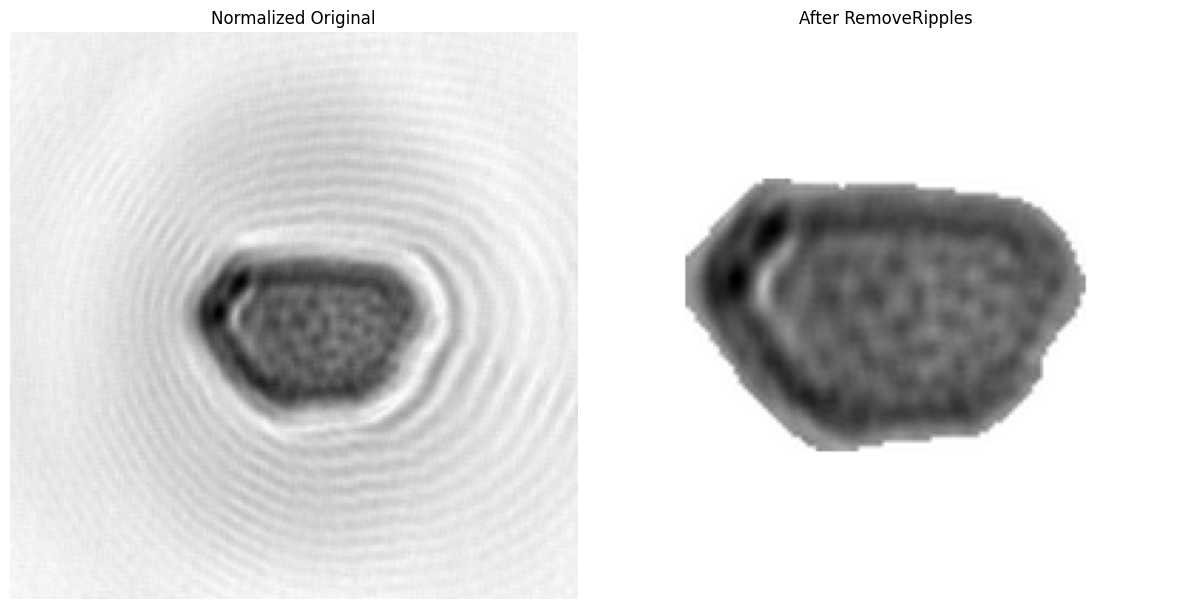

In [3]:
ripple_filter = RemoveRipples(
    method="otsu",
    blur_ksize=5,
    adaptive_blocksize=51,
    adaptive_C=2,
    morph_ksize=5,
    max_scale=1.7,
)

image_path = "../data/subset_poleno/g_carpinus_s_betulus/poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png"

img = Image.open(image_path)
arr = np.array(img).astype(np.float32)
min_val, max_val = arr.min(), arr.max()
if max_val > min_val:
    arr = (arr - min_val) / (max_val - min_val) * 255.0
else:
    arr = np.zeros_like(arr)
gray_img = Image.fromarray(arr.astype(np.uint8), mode="L")

filtered_img = ripple_filter(gray_img)

orig_arr = np.array(gray_img)
filtered_arr = np.array(filtered_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_arr, cmap="gray")
axes[0].set_title("Normalized Original")
axes[0].axis("off")

axes[1].imshow(filtered_arr, cmap="gray")
axes[1].set_title("After RemoveRipples")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [4]:
class HolographicPollenDataset(Dataset):
    def __init__(self, transform=None, extensions=None):
        self.root_dir = os.path.join(os.getenv("DATA_DIR_PATH"), "subset_poleno")
        self.transform = transform
        self.extensions = extensions or [".png"]

        self.classes = sorted(
            [
                d
                for d in os.listdir(self.root_dir)
                if os.path.isdir(os.path.join(self.root_dir, d))
            ]
        )

        raw_samples = []
        for taxa in self.classes:
            cls_dir = os.path.join(self.root_dir, taxa)
            for fname in os.listdir(cls_dir):
                if any(fname.lower().endswith(ext) for ext in self.extensions):
                    path = os.path.join(cls_dir, fname)
                    raw_samples.append((path, taxa))

        groups = {}
        for path, taxa in raw_samples:
            fname = os.path.basename(path)
            if "image_pairs" not in fname:
                continue
            base = fname.split("image_pairs")[0]
            groups.setdefault((base, taxa), []).append(path)

        # Build pairs list
        self.pairs = []  # (path0, path1, taxa_name)
        for (base, taxa), paths in groups.items():
            p0 = next((p for p in paths if ".0." in os.path.basename(p)), None)
            p1 = next((p for p in paths if ".1." in os.path.basename(p)), None)

            if p0 and p1:
                self.pairs.append((p0, p1, taxa))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path0, path1, taxa = self.pairs[idx]

        def load_and_normalize(p):
            img = Image.open(p)
            arr = np.array(img).astype(np.float32)
            mn, mx = arr.min(), arr.max()
            if mx > mn:
                arr = (arr - mn) / (mx - mn) * 255.0
            else:
                arr = np.zeros_like(arr)
            return Image.fromarray(arr.astype(np.uint8), mode="L")

        img0 = load_and_normalize(path0)
        img1 = load_and_normalize(path1)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Return images, taxa, and the paths for reference
        return {
            "images": (img0, img1),
            "taxa": taxa,
            "paths": (path0, path1),
            "image_pair_idx": idx,
        }


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        RemoveRipples(
            method="otsu",
            blur_ksize=5,
            adaptive_blocksize=51,
            adaptive_C=2,
            morph_ksize=5,
        ),
        transforms.ToTensor(),
    ]
)

dataset = HolographicPollenDataset(transform=transform)

In [5]:
# Test the dataset with new structure
sample = dataset[0]
print("Sample structure:")
print(f"Images shape: {sample['images'][0].shape}, {sample['images'][1].shape}")
print(f"Taxa: {sample['taxa']}")
print(f"Paths: {sample['paths'][0]}")
print(f"       {sample['paths'][1]}")
print(f"Image pair index: {sample['image_pair_idx']}")

# Check if the two images in the pair are equal
torch.all(
    sample["images"][0] == sample["images"][1]
)  # Check if the two images in the pair are equal

Sample structure:
Images shape: torch.Size([1, 224, 224]), torch.Size([1, 224, 224])
Taxa: g_carpinus_s_betulus
Paths: C:/Users/super/Documents/Github/sequoia/data\subset_poleno\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.27.896254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png
       C:/Users/super/Documents/Github/sequoia/data\subset_poleno\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.27.896254_ev.computed_data.holography.image_pairs.0.1.rec_mag.png
Image pair index: 0


C:\Users\super\AppData\Local\Temp\ipykernel_9932\354449685.py:54: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_9932\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


tensor(False)

In [6]:
# Generate 256x256 images using the dataset with paths
from pathlib import Path


def generate_256x256_images(dataset, output_dir="generated_holo_256", max_samples=10):
    """Generate 256x256 images from the holographic dataset."""

    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Create 256x256 transform
    transform_256 = transforms.Compose(
        [
            RemoveRipples(
                method="otsu",
                blur_ksize=5,
                adaptive_blocksize=51,
                adaptive_C=2,
                morph_ksize=5,
                max_scale=1.7,
            ),
            transforms.Resize(
                (256, 256), interpolation=transforms.InterpolationMode.LANCZOS
            ),
            transforms.ToTensor(),
        ]
    )

    print(
        f"Generating {min(max_samples, len(dataset))} samples at 256x256 resolution..."
    )

    for i in range(min(max_samples, len(dataset))):
        # Get original sample data
        sample = dataset[i]
        taxa = sample["taxa"]
        paths = sample["paths"]

        # Create taxa directory
        taxa_dir = output_path / taxa
        taxa_dir.mkdir(exist_ok=True)

        # Process each image in the pair
        for img_idx, img_path in enumerate(paths):
            # Load and process the original image (without dataset transform)
            img = Image.open(img_path)
            arr = np.array(img).astype(np.float32)
            mn, mx = arr.min(), arr.max()
            if mx > mn:
                arr = (arr - mn) / (mx - mn) * 255.0
            else:
                arr = np.zeros_like(arr)

            # Convert to PIL and apply 256x256 transform
            pil_img = Image.fromarray(arr.astype(np.uint8), mode="L")
            transformed_img = transform_256(pil_img)

            # Convert tensor back to PIL for saving
            if transformed_img.dim() == 3 and transformed_img.size(0) == 1:
                transformed_img = transformed_img.squeeze(0)

            img_array = (transformed_img.numpy() * 255).astype(np.uint8)
            final_img = Image.fromarray(img_array, mode="L")

            # Create filename from original path
            original_name = Path(img_path).stem
            output_filename = f"{original_name}_256x256.png"
            output_file = taxa_dir / output_filename

            # Save the image
            final_img.save(output_file)
            print(f"Saved: {output_file}")

    print(f"\nGeneration complete! Images saved to: {output_path}")


# Test with a few samples
generate_256x256_images(dataset, max_samples=5)

Generating 5 samples at 256x256 resolution...
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.27.896254_ev.computed_data.holography.image_pairs.0.0.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.27.896254_ev.computed_data.holography.image_pairs.0.1.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.1.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.0.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.1.rec_mag_256x256.png
Saved: generated_holo_256\g_carpinus_s_betulus\poleno-27_2023-04-0

C:\Users\super\AppData\Local\Temp\ipykernel_9932\354449685.py:54: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_9932\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_9932\64283392.py:56: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_9932\64283392.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  final_img = Image.fromarray(img_array, mode="L")


In [7]:
import sys

# move out of the current directory
sys.path.append("../")

from data import HolographicPolenoDataModule

In [8]:
datamodule = HolographicPolenoDataModule(
    batch_size=3, num_workers=0, image_transforms=transform
)

In [9]:
datamodule.setup("test")

for batch in datamodule.test_dataloader():
    print(batch[0][0].shape, batch[1])

torch.Size([3, 1, 224, 224]) ('g_carpinus_s_betulus', 'g_carpinus_s_betulus', 'g_carpinus_s_betulus')
torch.Size([3, 1, 224, 224]) ('g_fagus_s_sylvatica', 'g_fagus_s_sylvatica', 'g_fagus_s_sylvatica')
torch.Size([3, 1, 224, 224]) ('g_olea_s_europaea', 'g_olea_s_europaea', 'g_olea_s_europaea')
torch.Size([3, 1, 224, 224]) ('g_parietaria_s_officinalis', 'g_parietaria_s_officinalis', 'g_parietaria_s_officinalis')
torch.Size([3, 1, 224, 224]) ('g_picea_s_abies', 'g_picea_s_abies', 'g_picea_s_abies')
torch.Size([3, 1, 224, 224]) ('g_rumex_s_acetosella', 'g_rumex_s_acetosella', 'g_rumex_s_acetosella')
torch.Size([3, 1, 224, 224]) ('g_urtica_s_dioica', 'g_urtica_s_dioica', 'g_urtica_s_dioica')


C:\Users\super\AppData\Local\Temp\ipykernel_9932\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


In [10]:
results = pd.read_csv("../eval/Holo/mesh_eval_results_holo.csv")
display(results)

model                                          pred_path  \
0   pix2vox_aug_holo_test  C:\Users\super\Documents\Github\sequoia\TestEv...   
1   pix2vox_aug_holo_test  C:\Users\super\Documents\Github\sequoia\TestEv...   
2   pix2vox_aug_holo_test  C:\Users\super\Documents\Github\sequoia\TestEv...   
3   pix2vox_aug_holo_test  C:\Users\super\Documents\Github\sequoia\TestEv...   
4   pix2vox_aug_holo_test  C:\Users\super\Documents\Github\sequoia\TestEv...   
..                    ...                                                ...   
58     PixelNerf_aug_holo  C:\Users\super\Documents\Github\sequoia\TestEv...   
59     PixelNerf_aug_holo  C:\Users\super\Documents\Github\sequoia\TestEv...   
60     PixelNerf_aug_holo  C:\Users\super\Documents\Github\sequoia\TestEv...   
61     PixelNerf_aug_holo  C:\Users\super\Documents\Github\sequoia\TestEv...   
62     PixelNerf_aug_holo  C:\Users\super\Documents\Github\sequoia\TestEv...   

                                              gt_path  \
0   C:\Users\super\Documents\Github\sequoia\TestEv...   
1   C:\Users\super\Documents\Github\sequoia\TestEv...   
2   C:\Users\super\Documents\Github\sequoia\TestEv...   
3   C:\Users\super\Documents\Github\sequoia\TestEv...   
4   C:\Users\super\Documents\Github\sequoia\TestEv...   
..                                                ...   
58  C:\Users\super\Documents\Github\sequoia\TestEv...   
59  C:\Users\super\Documents\Github\sequoia\TestEv...   
60  C:\Users\super\Documents\Github\sequoia\TestEv...   
61  C:\Users\super\Documents\Github\sequoia\TestEv...   
62  C:\Users\super\Documents\Github\sequoia\TestEv...   

                     timestamp   chamfer  hausdorff  fscore_1  fscore_2_5  \
0   2022-09-07_12.08.31.154529  0.274747   0.518404  0.048304    0.155132   
1   2022-09-07_12.08.31.693529  0.365292   0.616100  0.049576    0.126858   
2   2022-09-07_12.08.31.693529  0.345845   0.578974  0.052269    0.143420   
3   2022-09-07_12.08.31.792529  0.321212   0.615109  0.042692    0.134813   
4   2022-09-07_12.08.31.792529  0.336484   0.627440  0.045842    0.138141   
..                         ...       ...        ...       ...         ...   
58  2023-05-05_10.14.49.372481  0.231173   0.464058  0.070095    0.213265   
59  2023-05-05_10.14.49.480481  0.263637   0.528333  0.068378    0.198498   
60  2022-09-07_12.08.31.693529  0.289123   0.560733  0.055495    0.165984   
61  2022-09-07_12.08.31.792529  0.239321   0.371761  0.042866    0.141532   
62  2022-09-07_12.08.31.947529  0.228630   0.468211  0.055722    0.213312   

    fscore_5                                          plot_path  ...  \
0   0.245371  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
1   0.211536  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
2   0.219657  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
3   0.210626  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
4   0.216667  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
..       ...                                                ...  ...   
58  0.341682  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
59  0.317766  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
60  0.257682  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
61  0.242672  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   
62  0.341129  C:\Users\super\Documents\Github\sequoia\TestEv...  ...   

    area_diff  edge_mean_pred  edge_std_pred  edge_mean_gt  edge_std_gt  \
0    7.345081        0.036331       0.009704      0.027024     0.006102   
1    7.021061        0.036286       0.009695      0.027459     0.006055   
2    7.021061        0.036286       0.009695      0.027459     0.006055   
3    7.716272        0.036562       0.009696      0.025141     0.005703   
4    7.716272        0.036562       0.009696      0.025141     0.005703   
..        ...             ...            ...           ...          ...   
58   6.860603        0.008211       0.003978      0.021240 

In [11]:
filtered = results

aggregated = filtered.groupby("model", as_index=False).agg(
    mean_chamfer=("chamfer", "mean"),
    std_chamfer=("chamfer", "std"),
    mean_fscore_1=("fscore_1", "mean"),
    std_fscore_1=("fscore_1", "std"),
    mean_fscore_2_5=("fscore_2_5", "mean"),
    std_fscore_2_5=("fscore_2_5", "std"),
    mean_fscore_5=("fscore_5", "mean"),
    std_fscore_5=("fscore_5", "std"),
    mean_iou=("voxel_iou", "mean"),
    std_iou=("voxel_iou", "std"),
)

aggregated

model  mean_chamfer  std_chamfer  mean_fscore_1  \
0     Pixel2MeshPlusPlus      0.170213     0.045721       0.082767   
1     PixelNerf_aug_holo      0.200071     0.064183       0.078835   
2  pix2vox_aug_holo_test      0.236172     0.065876       0.066713   

   std_fscore_1  mean_fscore_2_5  std_fscore_2_5  mean_fscore_5  std_fscore_5  \
0      0.026300         0.346151        0.081326       0.513292      0.095900   
1      0.029039         0.278215        0.107824       0.425491      0.148836   
2      0.020964         0.220725        0.086748       0.347931      0.128008   

   mean_iou   std_iou  
0  0.347238  0.091474  
1  0.282719  0.180242  
2  0.165041  0.139871

In [12]:
# Enhanced Holographic Pollen 3D Reconstruction Visualization System
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from PIL import Image
import trimesh
import warnings
import os
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

warnings.filterwarnings("ignore")

# Configuration
MAPPING_CSV = (
    "C:/Users/super/Documents/Github/sequoia/Eval/Holo/holo_file_mapping_corrected.csv"
)
MESH_BASE_DIR = (
    "C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo"
)
IMAGE_BASE_DIR = os.path.join(os.getenv("DATA_DIR_PATH", ""), "subset_poleno")

# Load mapping and results data
mapping_df = pd.read_csv(MAPPING_CSV)
try:
    results_df = pd.read_csv("../eval/Holo/mesh_eval_results_holo.csv")
except:
    results_df = None


class HolographicReconstructionVisualizer:
    """Enhanced visualization system with metrics integration and improved mesh rendering."""

    def __init__(
        self, mapping_df, mesh_base_dir, image_base_dir, dataset=None, results_df=None
    ):
        self.mapping_df = mapping_df
        self.mesh_base_dir = mesh_base_dir
        self.image_base_dir = image_base_dir
        self.dataset = dataset
        self.results_df = results_df
        self.mesh_types = [
            "gt_file",
            "pix2vox_file",
            "pixel2mesh_file",
            "pixelnerf_file",
        ]
        self.mesh_labels = [
            "Ground Truth\n(Visual Hull)",
            "Pix2Vox",
            "Pixel2Mesh",
            "PixelNeRF",
        ]
        self.model_names = ["vh_2img_holo", "pix2vox", "pixel2mesh", "pixelnerf"]
        self.mesh_colors = ["lightblue", "lightcoral", "lightgreen", "plum"]
        self.overlay_colors = ["lightblue", "lightcoral", "lightgreen", "plum"]
        # Maximum transparency for better overlap visualization
        self.alphas = [0.15, 0.15, 0.15, 0.15]
        self.edge_colors = ["darkblue", "darkred", "darkgreen", "indigo"]

    def load_and_normalize_image(self, image_path):
        """Load and normalize an image for display."""
        if not os.path.exists(image_path):
            return None

        img = Image.open(image_path)
        arr = np.array(img).astype(np.float32)
        if arr.max() > arr.min():
            arr = (arr - arr.min()) / (arr.max() - arr.min()) * 255.0
        else:
            arr = np.zeros_like(arr)
        return arr.astype(np.uint8)

    def find_image_pair_from_dataset(self, timestamp):
        """Find image pair from dataset using timestamp."""
        if self.dataset is None:
            return None, None

        for i in range(len(self.dataset)):
            sample = self.dataset[i]
            paths = sample["paths"]

            if any(timestamp in path for path in paths):
                img0 = sample["images"][0]
                img1 = sample["images"][1]

                if img0.dim() == 3 and img0.size(0) == 1:
                    img0 = img0.squeeze(0)
                if img1.dim() == 3 and img1.size(0) == 1:
                    img1 = img1.squeeze(0)

                img0_arr = (img0.numpy() * 255).astype(np.uint8)
                img1_arr = (img1.numpy() * 255).astype(np.uint8)

                return img0_arr, img1_arr

        return None, None

    def find_image_path_for_timestamp(self, timestamp):
        """Find the corresponding image file for a given timestamp."""
        for taxa_dir in Path(self.image_base_dir).iterdir():
            if taxa_dir.is_dir():
                for img_file in taxa_dir.iterdir():
                    if (
                        img_file.is_file()
                        and timestamp in img_file.name
                        and "image_pairs.0.0.rec_mag.png" in img_file.name
                    ):
                        return str(img_file)
        return None

    def find_mesh_file(self, filename, mesh_type=None):
        """Find a mesh file with robust search in all subfolders and for .obj extension, avoiding duplicates and matching species. Debug: print all found paths before returning. Für PixelNeRF: Suche nach exakt passender Spezies UND Zeitstempel."""
        if not os.path.exists(self.mesh_base_dir):
            return None

        # Für Ground Truth wie gehabt
        if mesh_type == "gt_file":
            gt_dir = os.path.join(self.mesh_base_dir, "vh_2img_holo_test")
            if os.path.exists(gt_dir):
                gt_path = os.path.join(gt_dir, filename)
                if os.path.exists(gt_path):
                    print(f"[DEBUG] GT found: {gt_path}")
                    return gt_path

        # PixelNeRF: Suche nach exakt passender Spezies UND Zeitstempel
        if mesh_type == "pixelnerf_file":
            import re

            # Extrahiere Spezies und Zeitstempel aus dem Dateinamen
            match = re.match(
                r"(g_[a-zA-Z0-9_]+).*(_2_\d{4}-\d{2}-\d{2}_\d{2}\.\d{2}\.\d{2}\.\d{6})\.obj",
                filename,
            )
            if match:
                species = match.group(1)
                timestamp = match.group(2)
                found_files = []
                for root, dirs, files in os.walk(self.mesh_base_dir):
                    for f in files:
                        if f.endswith(".obj") and species in f and timestamp in f:
                            found_files.append(os.path.join(root, f))
                if found_files:
                    # Wähle die Datei mit höchster Nummer (__XX oder _X), falls vorhanden
                    def extract_num(f):
                        m = re.search(r"__(\d+)_|_(\d+)_", f)
                        if m:
                            return int(m.group(1) or m.group(2))
                        return 0

                    found_files.sort(key=extract_num, reverse=True)
                    print(f"[DEBUG] PixelNeRF candidates for '{filename}':")
                    for p in found_files:
                        print(f"   {p}")
                    return found_files[0]
                else:
                    print(
                        f"[DEBUG] No PixelNeRF mesh file found for '{filename}' ({mesh_type})"
                    )
                return None

        # Standard-Suche für andere Typen
        found_files = []
        for root, dirs, files in os.walk(self.mesh_base_dir):
            for f in files:
                if (f == filename) or (filename in f and f.endswith(".obj")):
                    found_files.append(os.path.join(root, f))
        # Debug-Ausgabe aller gefundenen Pfade
        if found_files:
            print(f"[DEBUG] Found mesh files for '{filename}' ({mesh_type}):")
            for p in found_files:
                print(f"   {p}")
            return found_files[0]
        else:
            print(f"[DEBUG] No mesh file found for '{filename}' ({mesh_type})")
        return None

    def load_mesh_safe(self, mesh_path, verbose=False):
        """Safely load a mesh file."""
        try:
            if mesh_path and os.path.exists(mesh_path):
                return trimesh.load(mesh_path)
        except Exception:
            pass
        return None

    def get_metrics_for_timestamp(self, timestamp, model_name):
        """Get evaluation metrics for a specific timestamp and model."""
        if self.results_df is None:
            return None

        # Find matching row in results
        mask = (self.results_df["timestamp"] == timestamp) & (
            self.results_df["model"] == model_name
        )
        matching_rows = self.results_df[mask]

        if not matching_rows.empty:
            row = matching_rows.iloc[0]
            return {
                "chamfer": row.get("chamfer", None),
                "fscore_1": row.get("fscore_1", None),
                "fscore_2_5": row.get("fscore_2_5", None),
                "voxel_iou": row.get("voxel_iou", None),
            }
        return None

    def plot_mesh_with_wireframe(self, ax, mesh, color, alpha, edge_color, label):
        """Plot mesh with both surface and wireframe for better visibility."""
        vertices = mesh.vertices
        faces = mesh.faces

        # Plot surface with transparency
        ax.plot_trisurf(
            vertices[:, 0],
            vertices[:, 1],
            vertices[:, 2],
            triangles=faces,
            alpha=alpha,
            color=color,
            shade=True,
        )

        # Add wireframe for structure visibility
        # Subsample faces for wireframe to avoid clutter
        step = max(1, len(faces) // 200)  # Show max 200 triangles as wireframe
        wireframe_faces = faces[::step]

        for face in wireframe_faces:
            triangle = vertices[face]
            # Create triangle edges
            edges = [
                [triangle[0], triangle[1]],
                [triangle[1], triangle[2]],
                [triangle[2], triangle[0]],
            ]
            for edge in edges:
                ax.plot3D(*zip(*edge), color=edge_color, alpha=0.1, linewidth=0.1)

    def create_enhanced_legend(self, ax, colors, labels, alphas, metrics_list):
        """Create an enhanced legend with colors and metrics."""
        legend_elements = []

        for i, (color, label, alpha) in enumerate(zip(colors, labels, alphas)):
            # Base label
            clean_label = label.replace("\n", " ")

            # Add metrics if available
            if i < len(metrics_list) and metrics_list[i]:
                metrics = metrics_list[i]
                metrics_str = []
                if metrics.get("chamfer") is not None:
                    metrics_str.append(f"CD: {metrics['chamfer']:.3f}")
                if metrics.get("fscore_1") is not None:
                    metrics_str.append(f"F1: {metrics['fscore_1']:.3f}")
                if metrics.get("voxel_iou") is not None:
                    metrics_str.append(f"IoU: {metrics['voxel_iou']:.3f}")

                if metrics_str:
                    clean_label += f"\n{' | '.join(metrics_str)}"

            legend_elements.append(
                Rectangle((0, 0), 1, 1, facecolor=color, alpha=alpha, label=clean_label)
            )

        ax.legend(
            handles=legend_elements,
            loc="upper left",
            bbox_to_anchor=(0.02, 0.98),
            fontsize=8,
            framealpha=0.95,
        )

    def create_color_legend(self, ax, colors, labels, alphas):
        """Create a colored legend for the overlay plot."""
        legend_elements = []
        for color, label, alpha in zip(colors, labels, alphas):
            legend_elements.append(
                Rectangle(
                    (0, 0),
                    1,
                    1,
                    facecolor=color,
                    alpha=alpha,
                    label=label.replace("\n", " "),
                )
            )

        ax.legend(
            handles=legend_elements,
            loc="upper left",
            bbox_to_anchor=(0.02, 0.98),
            fontsize=9,
            framealpha=0.9,
        )

    def plot_single_comparison(self, timestamp, verbose=False):
        """Vergleichsplot ohne Overlay und ohne Achsen. Titelgröße für alle Modelle auf 12."""
        row = self.mapping_df[self.mapping_df["timestamp"] == timestamp]
        if row.empty:
            return None

        row = row.iloc[0]

        # Get image pair from dataset
        img0_arr, img1_arr = self.find_image_pair_from_dataset(timestamp)

        if img0_arr is None or img1_arr is None:
            image_path = self.find_image_path_for_timestamp(timestamp)
            if not image_path:
                return None
            image_arr = self.load_and_normalize_image(image_path)
            if image_arr is None:
                return None
            img0_arr = img1_arr = image_arr

        fig = plt.figure(figsize=(20, 5))

        ax_img0 = plt.subplot(1, 6, 1)
        ax_img0.imshow(img0_arr, cmap="gray")
        ax_img0.set_title(
            "Input Image 0\n(Holographic)", fontsize=12, fontweight="bold"
        )
        ax_img0.axis("off")

        ax_img1 = plt.subplot(1, 6, 2)
        ax_img1.imshow(img1_arr, cmap="gray")
        ax_img1.set_title(
            "Input Image 1\n(Holographic)", fontsize=12, fontweight="bold"
        )
        ax_img1.axis("off")

        # Meshes ohne Achsen und mit Titelgröße 12
        for i, (mesh_type, label, color, model_name) in enumerate(
            zip(self.mesh_types, self.mesh_labels, self.mesh_colors, self.model_names)
        ):
            mesh = None
            metrics = None
            mesh_title = label

            if pd.notna(row[mesh_type]):
                mesh_filename = row[mesh_type]
                mesh_path = self.find_mesh_file(mesh_filename, mesh_type)
                if mesh_path:
                    mesh = self.load_mesh_safe(mesh_path, verbose)
            ax = fig.add_subplot(1, 6, i + 3, projection="3d")

            if mesh is not None:
                vertices = mesh.vertices
                faces = mesh.faces

                ax.plot_trisurf(
                    vertices[:, 0],
                    vertices[:, 1],
                    vertices[:, 2],
                    triangles=faces,
                    alpha=0.7,
                    color=color,
                    shade=True,
                )
                ax.set_title(mesh_title, fontsize=12, fontweight="bold", color="black")
            else:
                mesh_filename = (
                    row[mesh_type] if pd.notna(row[mesh_type]) else "No mapping"
                )
                ax.text(
                    0.5,
                    0.5,
                    0.5,
                    f"Not available\n{mesh_filename[:20]}...",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=ax.transAxes,
                    fontsize=8,
                    color="red" if pd.notna(row[mesh_type]) else "gray",
                )
                ax.set_title(
                    f"{mesh_title}\nMissing",
                    fontsize=12,
                    color="red" if pd.notna(row[mesh_type]) else "gray",
                )

            ax.set_axis_off()

        # Species name extraction for plot title
        species_name = "Unknown"
        pixelnerf_filename = (
            row["pixelnerf_file"]
            if "pixelnerf_file" in row and pd.notna(row["pixelnerf_file"])
            else None
        )
        if pixelnerf_filename:
            import re

            # Extrahiere nur den reinen Artnamen (z.B. 'Carpinus betulus')
            match = re.match(r"g_([a-zA-Z]+)_s_([a-zA-Z]+)", pixelnerf_filename)
            if match:
                species_name = f"{match.group(1).capitalize()} {match.group(2).lower()}"
            else:
                # Fallback: alles bis zum ersten doppelten Unterstrich, _2_ oder Datum, dann Wörter extrahieren
                cleaned = re.split(r"__|_2_|_\d{4}-\d{2}-\d{2}", pixelnerf_filename)[0]
                cleaned = cleaned.replace("g_", "").replace("_s_", " ")
                # Nur die ersten zwei Wörter nehmen
                species_name = " ".join(cleaned.split()[:2]).capitalize()
        else:
            if self.dataset:
                for i in range(len(self.dataset)):
                    sample = self.dataset[i]
                    if any(timestamp in path for path in sample["paths"]):
                        match = re.match(
                            r"g_([a-zA-Z]+)_s_([a-zA-Z]+)", sample["taxa"] or ""
                        )
                        if match:
                            species_name = f"{match.group(1).capitalize()} {match.group(2).lower()}"
                        else:
                            cleaned = (
                                sample["taxa"].replace("g_", "").replace("_s_", " ")
                            )
                            species_name = " ".join(cleaned.split()[:2]).capitalize()
                        break
            else:
                image_path = self.find_image_path_for_timestamp(timestamp)
                if image_path:
                    parent = Path(image_path).parent.name
                    match = re.match(r"g_([a-zA-Z]+)_s_([a-zA-Z]+)", parent)
                    if match:
                        species_name = (
                            f"{match.group(1).capitalize()} {match.group(2).lower()}"
                        )
                    else:
                        cleaned = parent.replace("g_", "").replace("_s_", " ")
                        species_name = " ".join(cleaned.split()[:2]).capitalize()

        plt.suptitle(
            f"Reconstruction Comparison - {species_name}",
            fontsize=16,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()

        return fig

    def process_all_reconstructions(self):
        """Process all reconstructions and create visualizations."""
        successful_plots = 0
        failed_plots = 0

        for i, (_, row) in enumerate(self.mapping_df.iterrows()):
            timestamp = row["timestamp"]

            try:
                fig = self.plot_single_comparison(timestamp, verbose=False)
                if fig is not None:
                    successful_plots += 1
                else:
                    failed_plots += 1
            except Exception:
                failed_plots += 1

        return {
            "successful": successful_plots,
            "failed": failed_plots,
            "total": len(self.mapping_df),
        }

    def create_overview_grid(self):
        """Create a summary grid of all reconstructions."""
        samples_to_show = len(self.mapping_df)
        rows = int(np.ceil(np.sqrt(samples_to_show)))
        cols = int(np.ceil(samples_to_show / rows))

        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)
        if cols == 1:
            axes = axes.reshape(-1, 1)

        for i in range(samples_to_show):
            row_idx = i // cols
            col_idx = i % cols
            ax = axes[row_idx, col_idx]

            timestamp = self.mapping_df.iloc[i]["timestamp"]

            # Try to get image from dataset first
            img0_arr, img1_arr = self.find_image_pair_from_dataset(timestamp)

            if img0_arr is not None:
                ax.imshow(img0_arr, cmap="gray")

                taxa = "Unknown"
                if self.dataset:
                    for j in range(len(self.dataset)):
                        sample = self.dataset[j]
                        if any(timestamp in path for path in sample["paths"]):
                            taxa = sample["taxa"].replace("g_", "").replace("_s_", " ")
                            break

                ax.set_title(f"{taxa}\n{timestamp[:10]}", fontsize=6)
            else:
                # Fallback method
                image_path = self.find_image_path_for_timestamp(timestamp)
                if image_path:
                    image_arr = self.load_and_normalize_image(image_path)
                    if image_arr is not None:
                        ax.imshow(image_arr, cmap="gray")
                        taxa = (
                            Path(image_path)
                            .parent.name.replace("g_", "")
                            .replace("_s_", " ")
                        )
                        ax.set_title(f"{taxa}\n{timestamp[:10]}", fontsize=6)
                    else:
                        ax.text(
                            0.5,
                            0.5,
                            "Error",
                            ha="center",
                            va="center",
                            transform=ax.transAxes,
                        )
                        ax.set_title(f"Error\n{timestamp[:10]}", fontsize=6)
                else:
                    ax.text(
                        0.5,
                        0.5,
                        "Not Found",
                        ha="center",
                        va="center",
                        transform=ax.transAxes,
                    )
                    ax.set_title(f"Missing\n{timestamp[:10]}", fontsize=6)

            ax.axis("off")

        # Hide unused subplots
        for i in range(samples_to_show, rows * cols):
            row_idx = i // cols
            col_idx = i % cols
            axes[row_idx, col_idx].axis("off")

        plt.suptitle(
            f"Overview: {samples_to_show} Holographic Pollen Reconstructions",
            fontsize=16,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()


# Initialize the enhanced visualizer with metrics support
visualizer = HolographicReconstructionVisualizer(
    mapping_df, MESH_BASE_DIR, IMAGE_BASE_DIR, dataset=dataset, results_df=results_df
)

In [13]:
# Production-Ready Functions


def show_overview():
    """Show overview grid of all reconstructions using DataLoader images."""
    visualizer.create_overview_grid()


def process_all():
    """Process and visualize all reconstructions with both holographic images."""
    results = visualizer.process_all_reconstructions()
    print(f"\nProcessing complete:")
    print(f"Successful: {results['successful']}/{results['total']}")
    print(f"Failed: {results['failed']}/{results['total']}")
    print(f"Success rate: {results['successful']/results['total']*100:.1f}%")


def show_specific(indices):
    """Show specific reconstructions by index with both holographic images."""
    if not isinstance(indices, list):
        indices = [indices]

    for idx in indices:
        if 0 <= idx < len(mapping_df):
            timestamp = mapping_df.iloc[idx]["timestamp"]
            visualizer.plot_single_comparison(timestamp, verbose=False)
        else:
            print(f"Index {idx} out of range (0-{len(mapping_df)-1})")


def show_random(n=3):
    """Show n random reconstructions with both holographic images."""
    import random

    indices = random.sample(range(len(mapping_df)), min(n, len(mapping_df)))
    show_specific(indices)


def test_dataloader_integration():
    """Test if DataLoader integration is working properly."""
    if len(mapping_df) > 0:
        timestamp = mapping_df.iloc[0]["timestamp"]
        img0, img1 = visualizer.find_image_pair_from_dataset(timestamp)
        if img0 is not None and img1 is not None:
            print("DataLoader integration working")
            return True
        else:
            print("DataLoader integration failed")
            return False
    else:
        print("No mapping data available")
        return False


def test_metrics_integration():
    """Test if evaluation metrics are available and integrated."""
    if results_df is not None:
        print("Metrics integration available")
        print(f"Available metrics: {list(results_df.columns)}")
        return True
    else:
        print("No evaluation metrics found")
        return False


# Enhanced Usage Guide
print("=" * 70)
print("ENHANCED HOLOGRAPHIC RECONSTRUCTION VISUALIZER")
print("=" * 70)
print("Functions:")
print("- show_overview() - Grid overview of all samples")
print("- process_all() - Visualize all reconstructions with metrics")
print("- show_specific([0,1,2]) - Show specific indices with metrics")
print("- show_random(3) - Show random samples with metrics")
print("- test_dataloader_integration() - Test DataLoader")
print("- test_metrics_integration() - Test metrics availability")
print("=" * 70)

ENHANCED HOLOGRAPHIC RECONSTRUCTION VISUALIZER
Functions:
- show_overview() - Grid overview of all samples
- process_all() - Visualize all reconstructions with metrics
- show_specific([0,1,2]) - Show specific indices with metrics
- show_random(3) - Show random samples with metrics
- test_dataloader_integration() - Test DataLoader
- test_metrics_integration() - Test metrics availability


Testing enhanced system integration...
DataLoader integration working
Metrics integration available
Available metrics: ['model', 'pred_path', 'gt_path', 'timestamp', 'chamfer', 'hausdorff', 'fscore_1', 'fscore_2_5', 'fscore_5', 'plot_path', 'compare_path', 'vol_diff', 'area_diff', 'edge_mean_pred', 'edge_std_pred', 'edge_mean_gt', 'edge_std_gt', 'voxel_iou', 'euler_pred', 'euler_gt', 'normal_consistency', 'voxel_plot_path']

System Status:
DataLoader: ✓
Metrics: ✓

Full enhanced system ready! Processing with wireframes, transparency, and metrics...
[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\polen

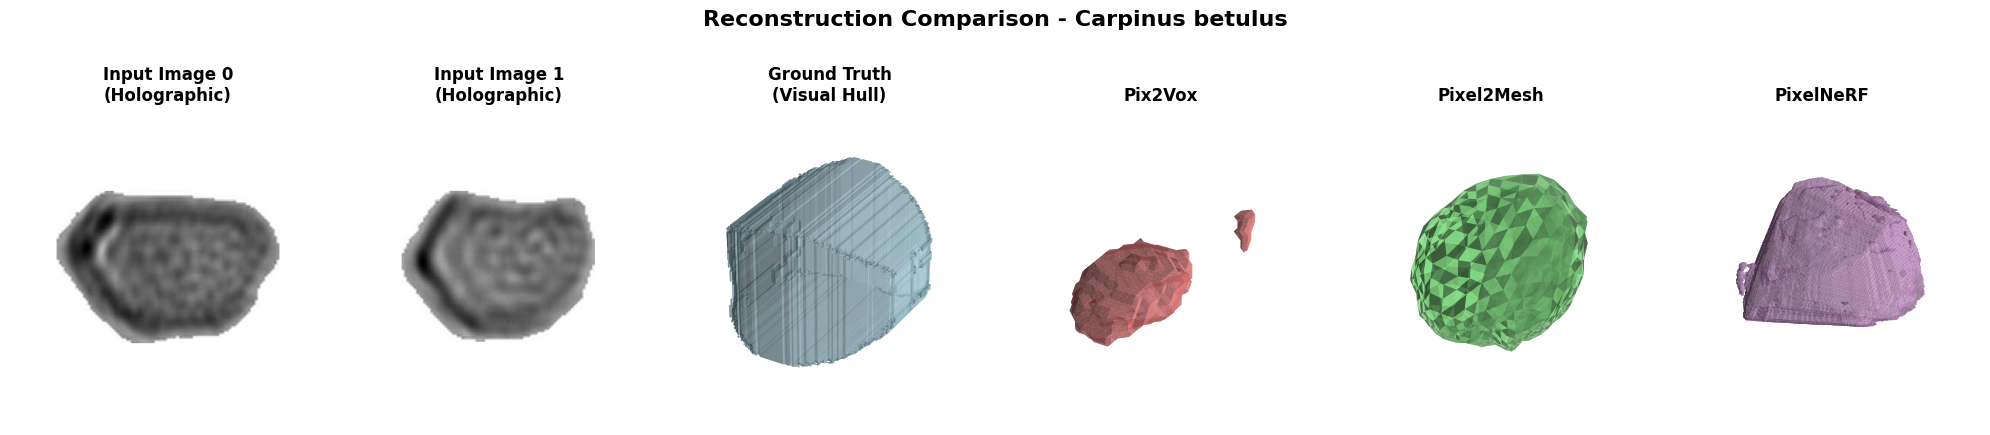

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-27_2023-04-06_18.06.28.401254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_carpinus_s_betulus_27_2023-04-06_18.06.28.401254.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_carpinus_s_betulus_27_2023-04-06_18.06.28.401254.obj
[DEBUG] Found mesh files 

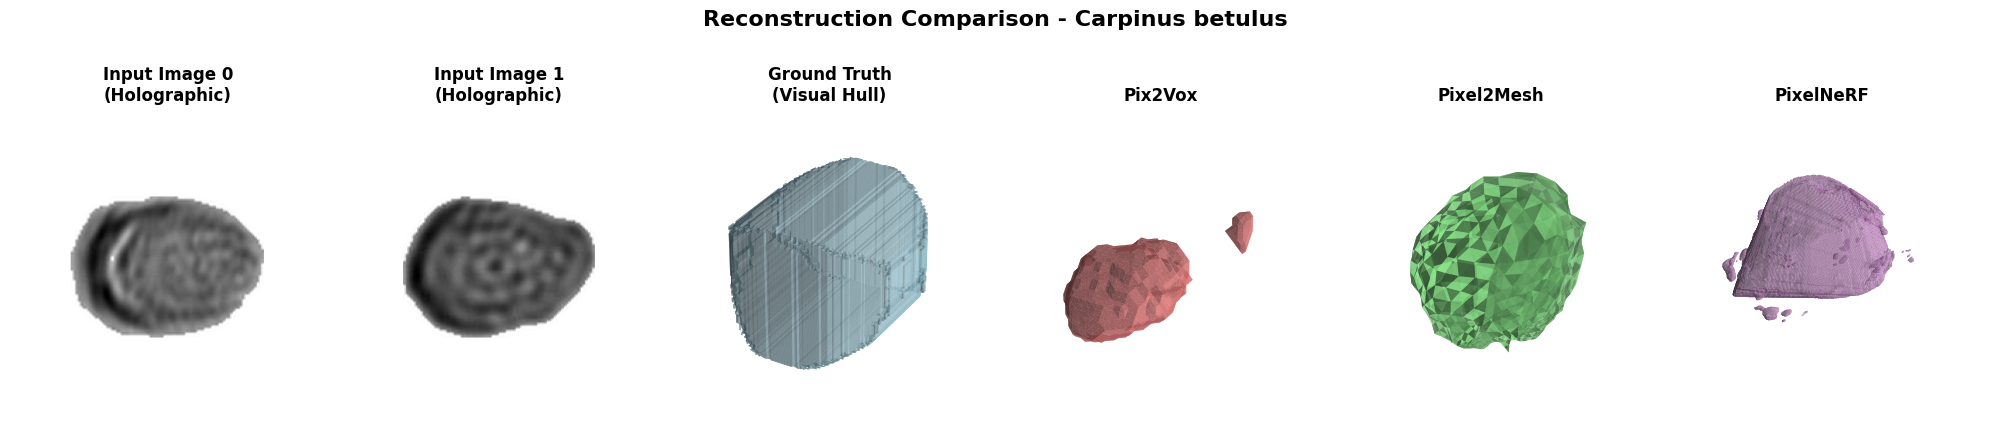

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-27_2023-04-06_18.06.28.963254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-27_2023-04-06_18.06.28.963254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-27_2023-04-06_18.06.28.963254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-27_2023-04-06_18.06.28.963254_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_carpinus_s_betulus_27_2023-04-06_18.06.28.963254.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_carpinus_s_betulus_27_2023-04-06_18.06.28.963254.obj
[DEBUG] Found mesh files 

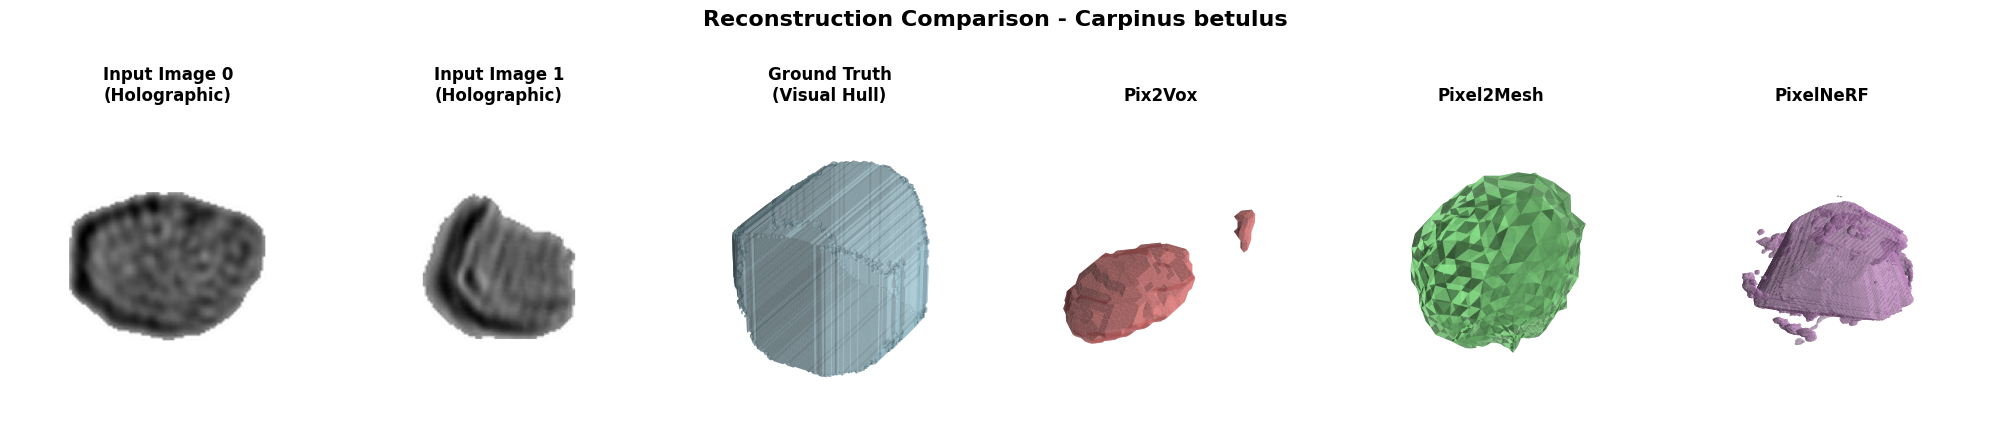

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.25.490385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-22_2023-05-04_13.20.25.490385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-22_2023-05-04_13.20.25.490385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.25.490385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_fagus_s_sylvatica_22_2023-05-04_13.20.25.490385.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_fagus_s_sylvatica_22_2023-05-04_13.20.25.490385.obj
[DEBUG] Found mesh files fo

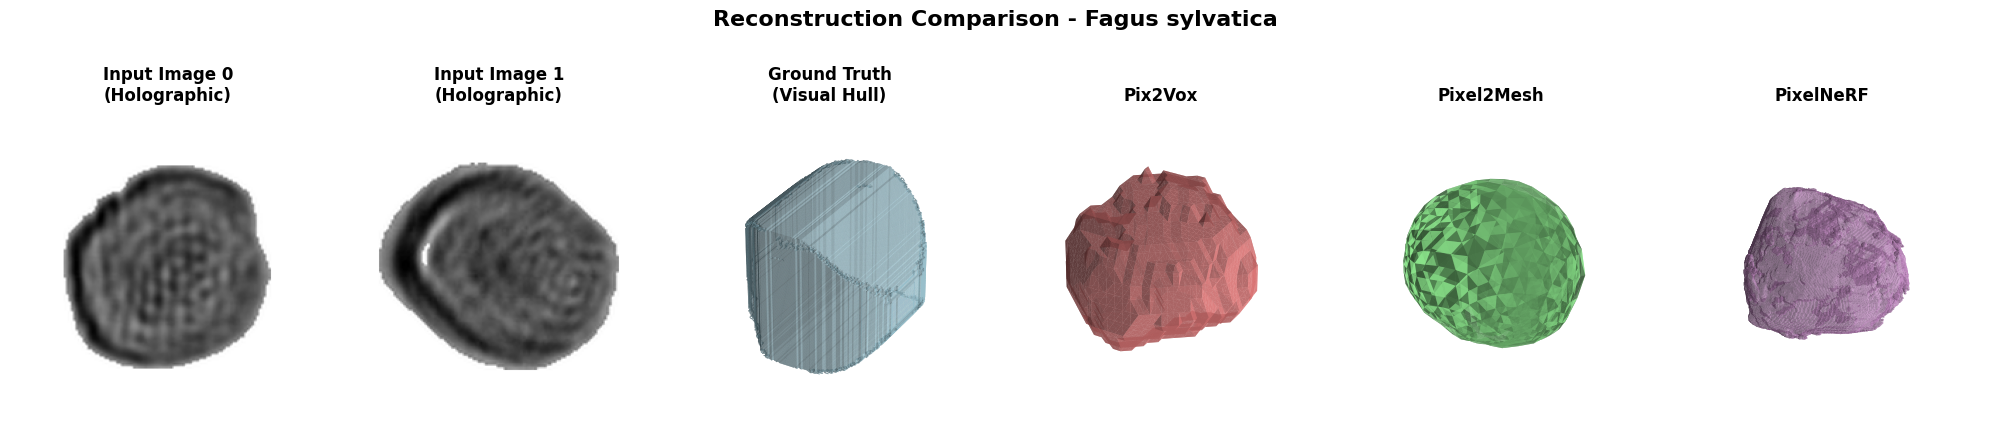

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.25.568385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-22_2023-05-04_13.20.25.568385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-22_2023-05-04_13.20.25.568385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.25.568385_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_fagus_s_sylvatica_22_2023-05-04_13.20.25.568385.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_fagus_s_sylvatica_22_2023-05-04_13.20.25.568385.obj
[DEBUG] Found mesh files fo

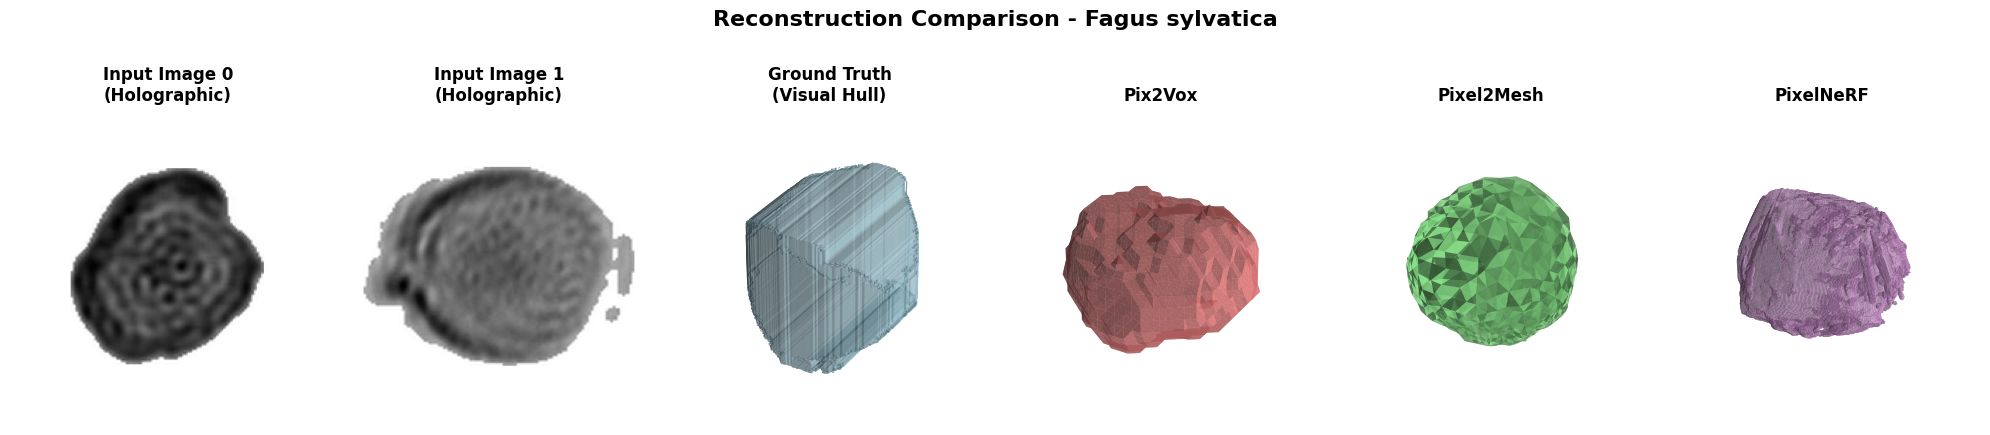

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.28.024384_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-22_2023-05-04_13.20.28.024384_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-22_2023-05-04_13.20.28.024384_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-22_2023-05-04_13.20.28.024384_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_fagus_s_sylvatica_22_2023-05-04_13.20.28.024384.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_fagus_s_sylvatica_22_2023-05-04_13.20.28.024384.obj
[DEBUG] Found mesh files fo

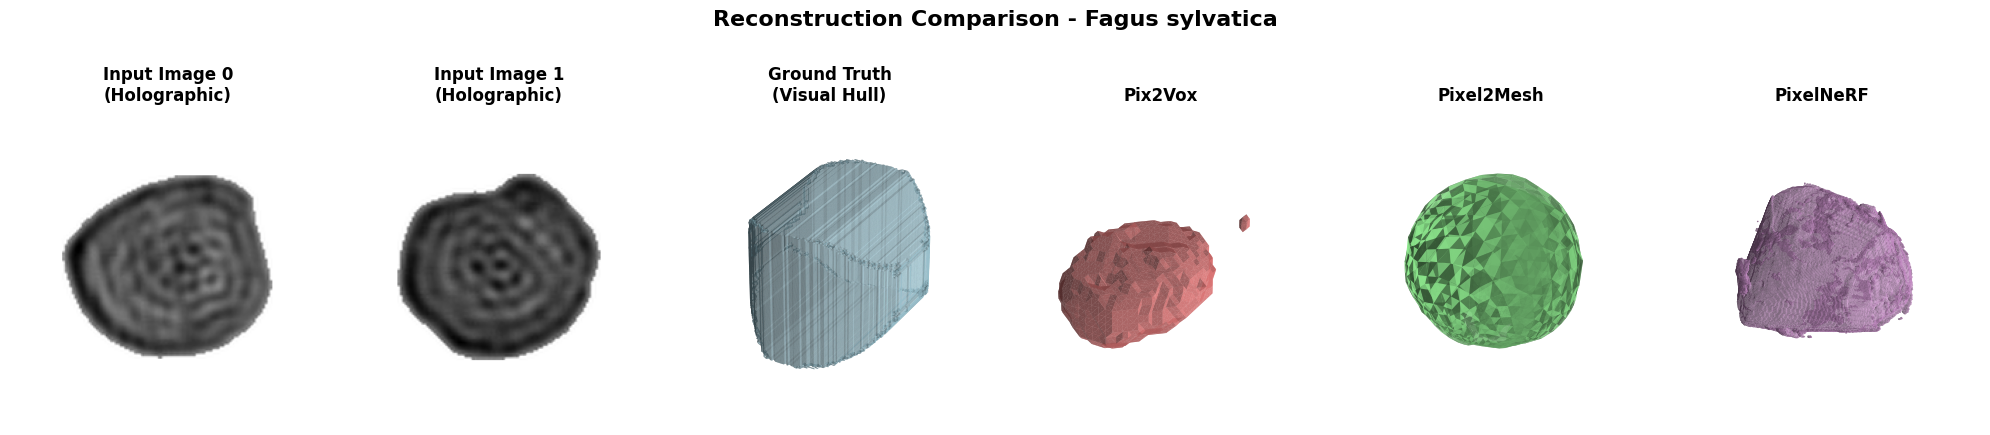

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.089087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-15_2023-04-06_13.19.30.089087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-15_2023-04-06_13.19.30.089087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.089087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_olea_s_europaea_15_2023-04-06_13.19.30.089087.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_olea_s_europaea_15_2023-04-06_13.19.30.089087.obj
[DEBUG] Found mesh files for 'g

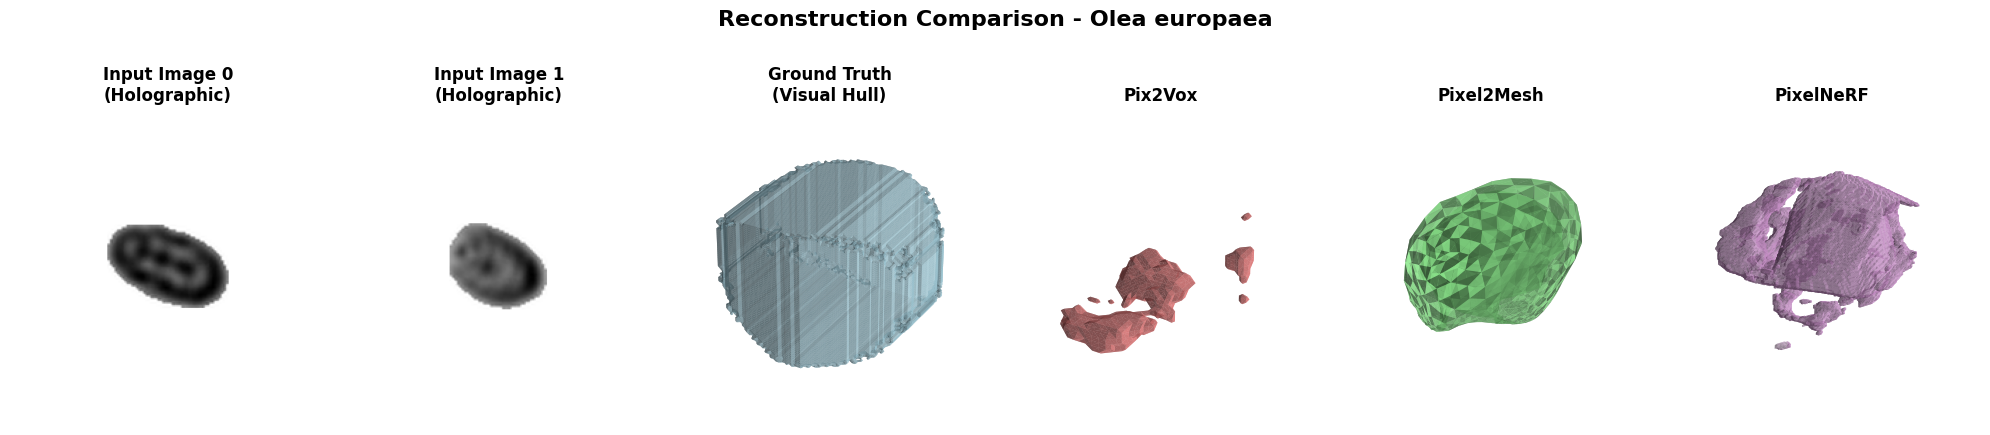

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.213087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-15_2023-04-06_13.19.30.213087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-15_2023-04-06_13.19.30.213087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.213087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_olea_s_europaea_15_2023-04-06_13.19.30.213087.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_olea_s_europaea_15_2023-04-06_13.19.30.213087.obj
[DEBUG] Found mesh files for 'g

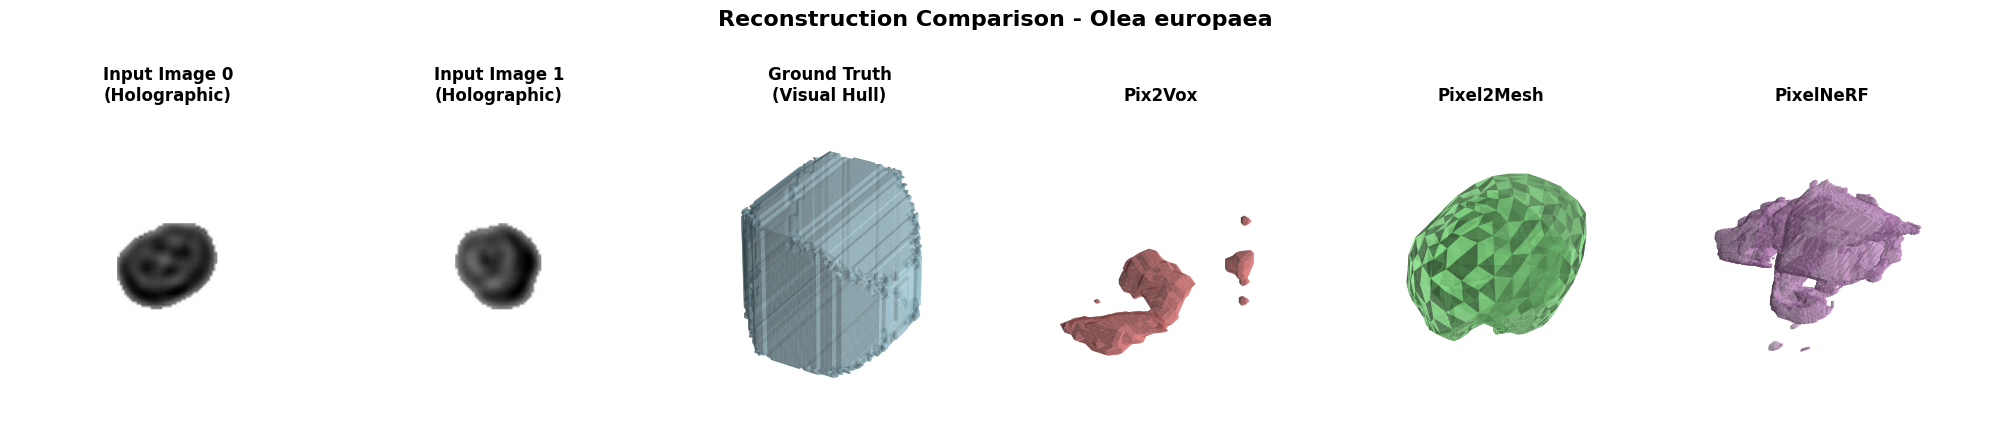

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.465087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-15_2023-04-06_13.19.30.465087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-15_2023-04-06_13.19.30.465087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-15_2023-04-06_13.19.30.465087_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_olea_s_europaea_15_2023-04-06_13.19.30.465087.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_olea_s_europaea_15_2023-04-06_13.19.30.465087.obj
[DEBUG] Found mesh files for 'g

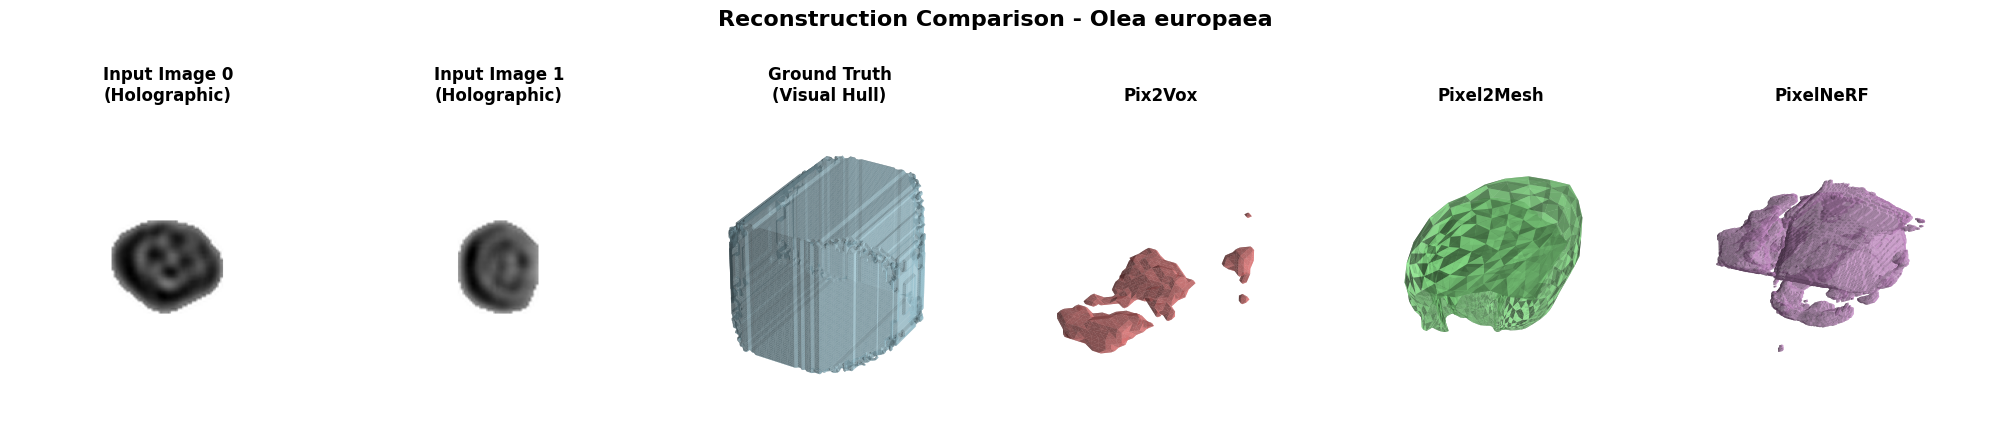

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.154529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.154529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.154529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.154529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_parietaria_s_officinalis_14_2022-09-07_12.08.31.154529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_parietaria_s_officinalis_14_2022-09-07_12.08.31.154529.obj
[DEBUG] Found

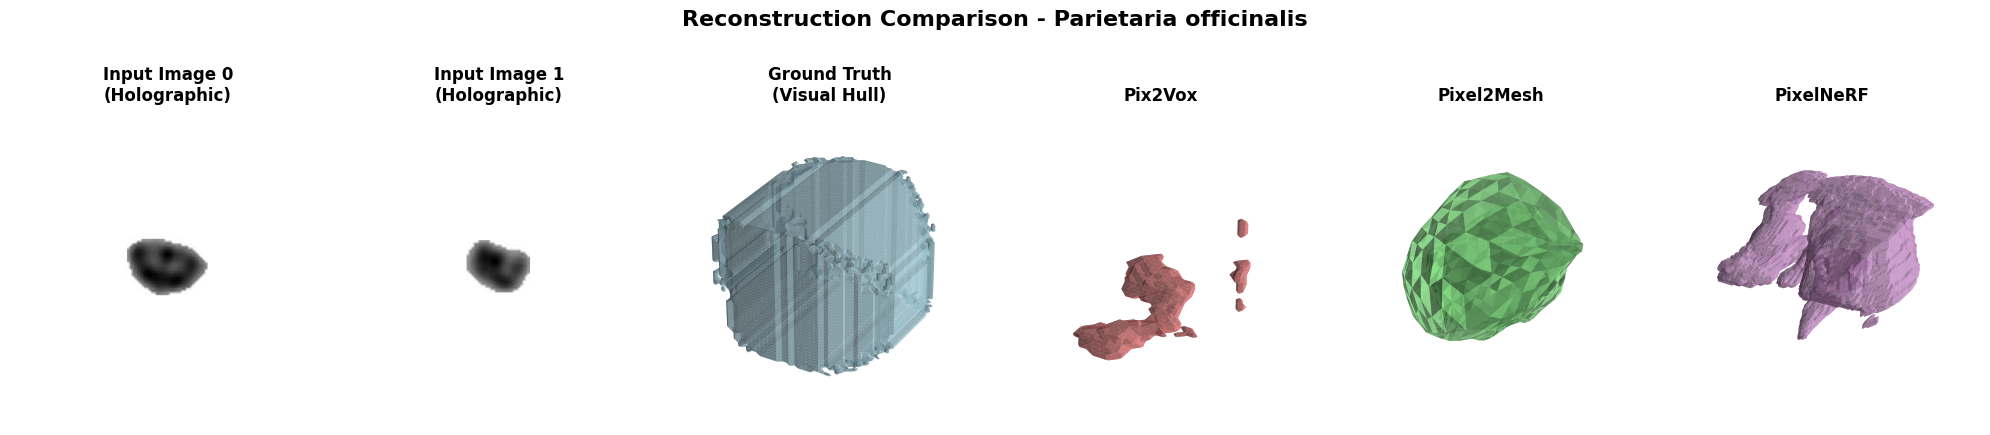

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_parietaria_s_officinalis_14_2022-09-07_12.08.31.693529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_parietaria_s_officinalis_14_2022-09-07_12.08.31.693529.obj
[DEBUG] Found

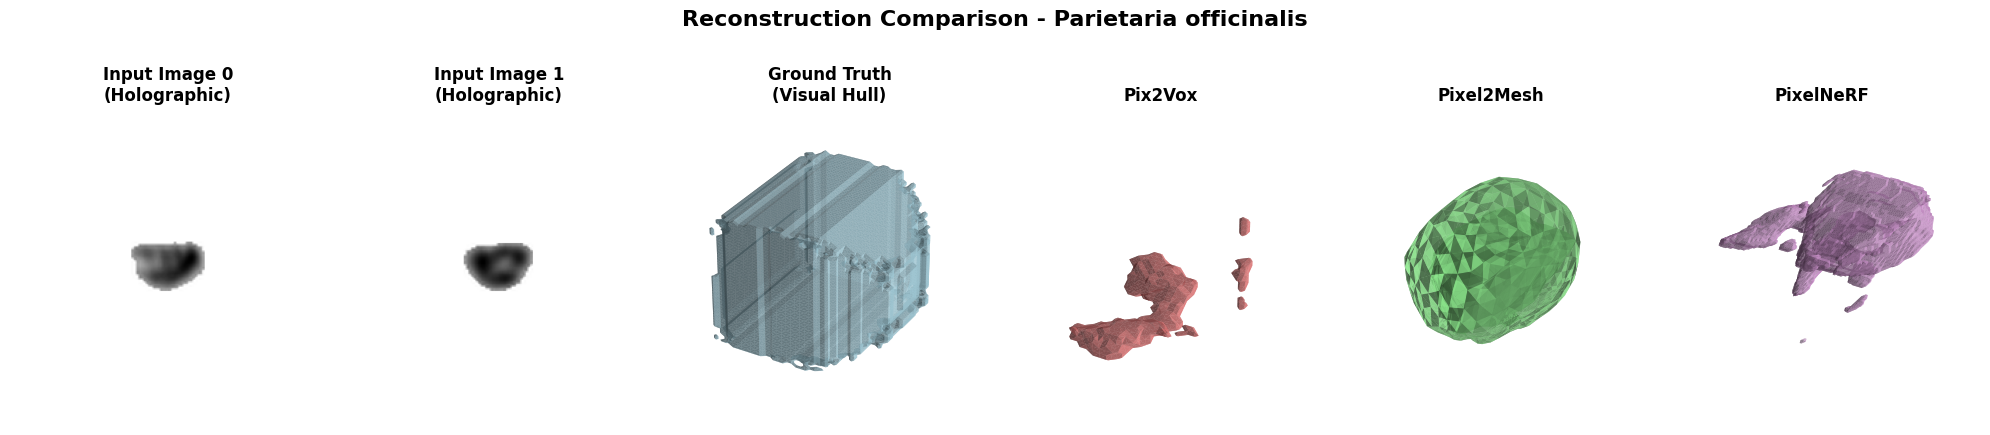

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_parietaria_s_officinalis_14_2022-09-07_12.08.31.792529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_parietaria_s_officinalis_14_2022-09-07_12.08.31.792529.obj
[DEBUG] Found

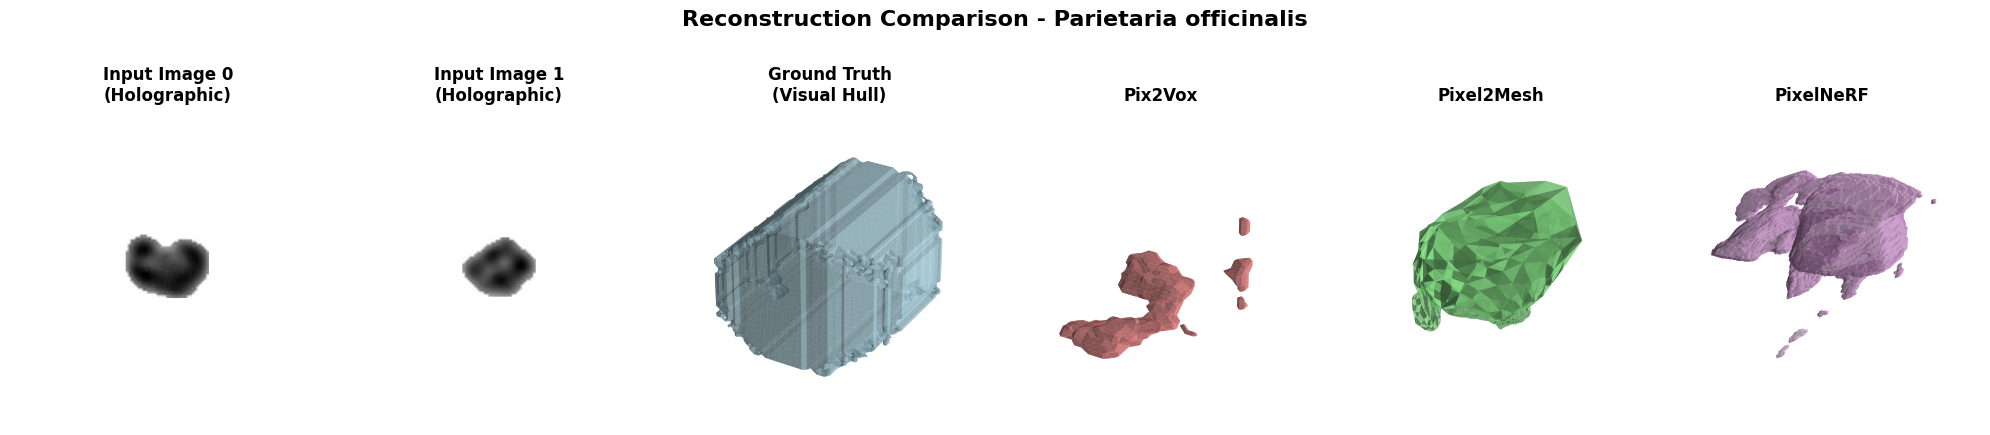

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.08.621796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_08.09.08.621796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_08.09.08.621796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.08.621796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_picea_s_abies_2_2023-05-05_08.09.08.621796.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_picea_s_abies_2_2023-05-05_08.09.08.621796.obj
[DEBUG] Found mesh files for 'poleno-2_20

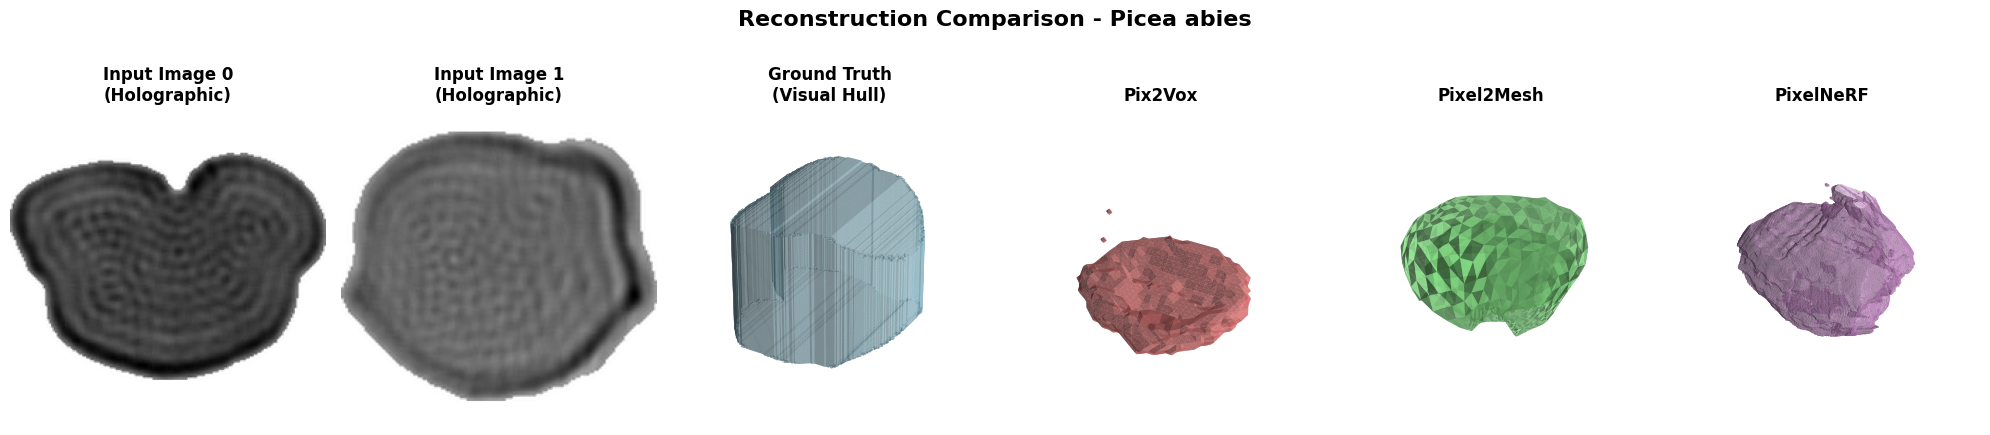

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.07.396796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_08.09.07.396796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_08.09.07.396796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.07.396796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_picea_s_abies_2_2023-05-05_08.09.07.396796.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_picea_s_abies_2_2023-05-05_08.09.07.396796.obj
[DEBUG] PixelNeRF candidates for 'g_picea

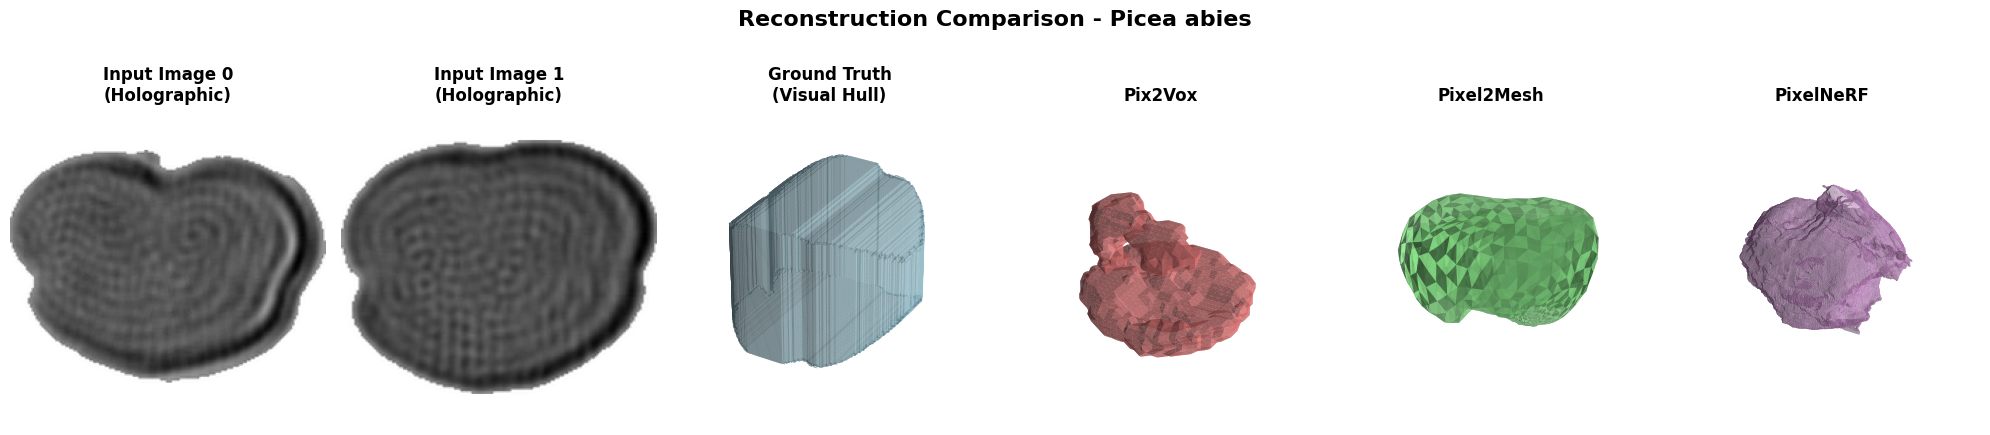

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.07.572796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_08.09.07.572796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_08.09.07.572796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_08.09.07.572796_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_picea_s_abies_2_2023-05-05_08.09.07.572796.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_picea_s_abies_2_2023-05-05_08.09.07.572796.obj
[DEBUG] Found mesh files for 'poleno-2_20

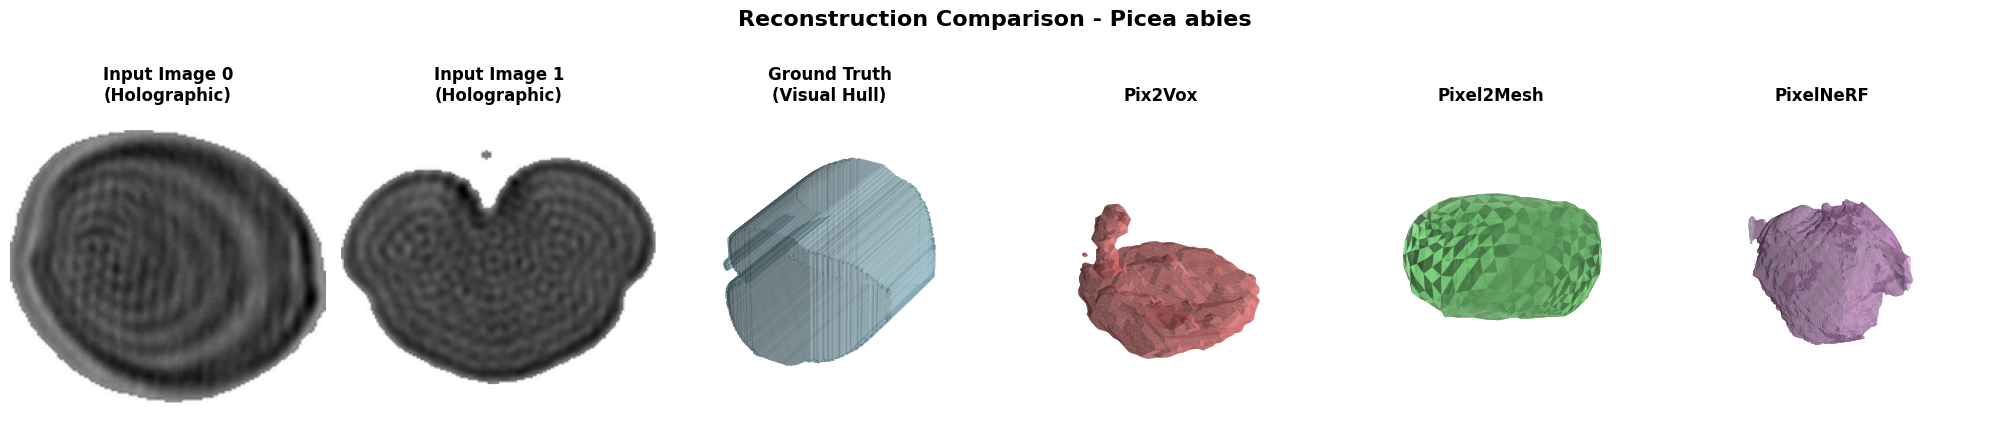

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.092481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_10.14.49.092481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_10.14.49.092481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.092481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_rumex_s_acetosella_2_2023-05-05_10.14.49.092481.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_rumex_s_acetosella_2_2023-05-05_10.14.49.092481.obj
[DEBUG] PixelNeRF candidates fo

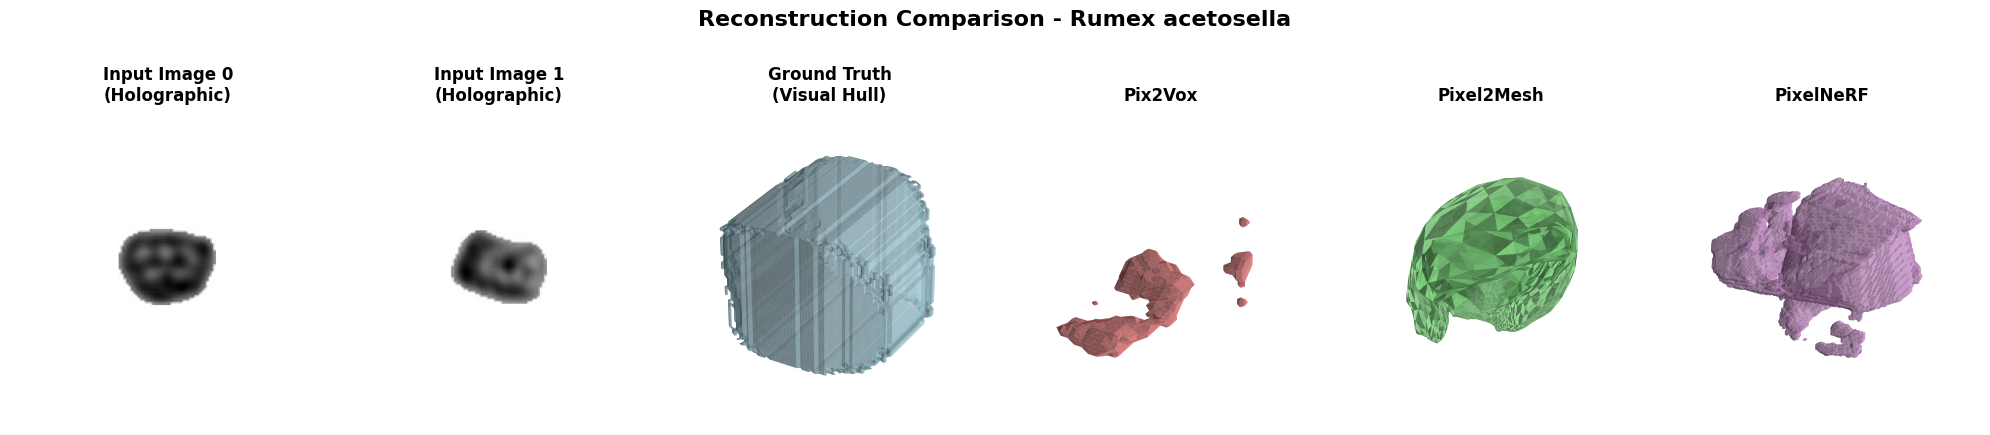

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.372481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_10.14.49.372481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_10.14.49.372481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.372481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_rumex_s_acetosella_2_2023-05-05_10.14.49.372481.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_rumex_s_acetosella_2_2023-05-05_10.14.49.372481.obj
[DEBUG] PixelNeRF candidates fo

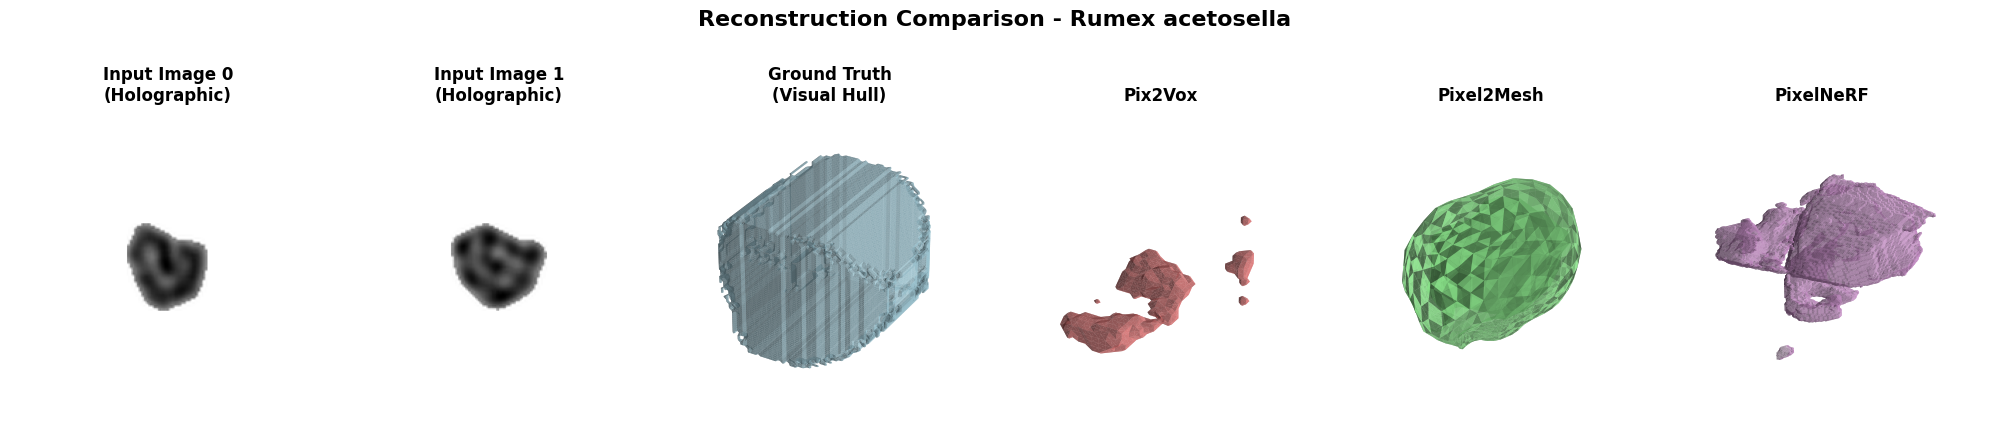

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.480481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-2_2023-05-05_10.14.49.480481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-2_2023-05-05_10.14.49.480481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-2_2023-05-05_10.14.49.480481_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_rumex_s_acetosella_2_2023-05-05_10.14.49.480481.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_rumex_s_acetosella_2_2023-05-05_10.14.49.480481.obj
[DEBUG] PixelNeRF candidates fo

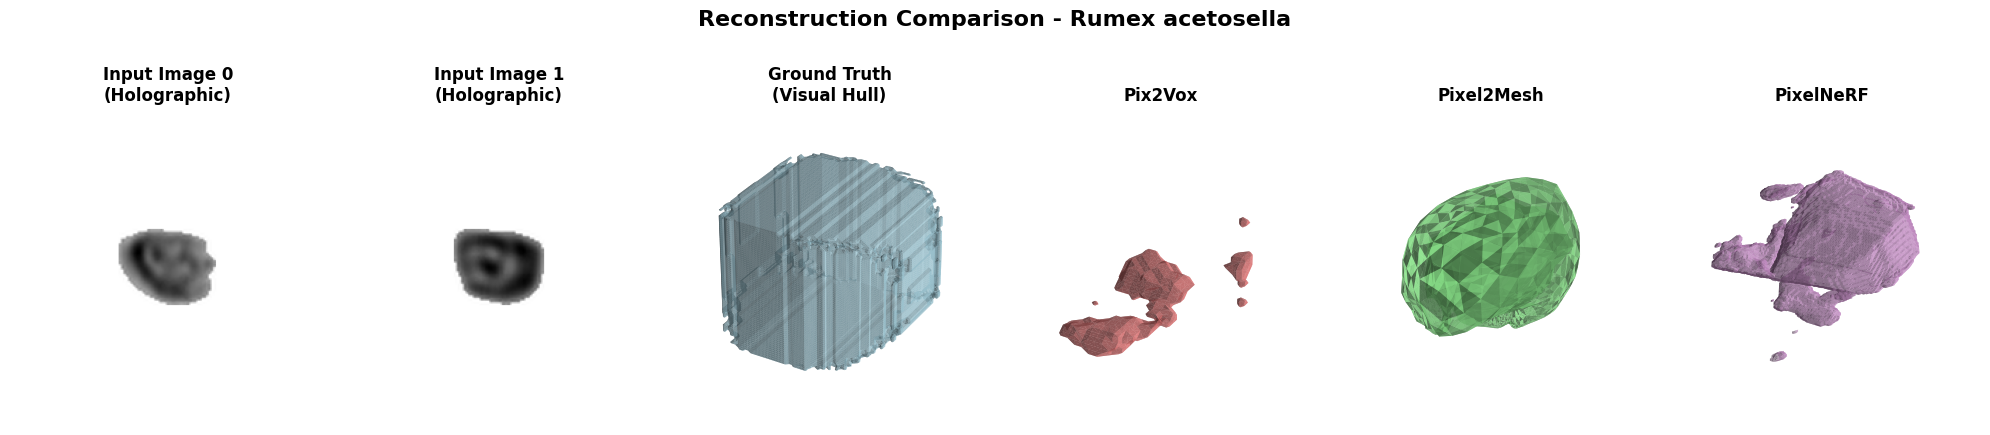

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.693529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_parietaria_s_officinalis_14_2022-09-07_12.08.31.693529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_parietaria_s_officinalis_14_2022-09-07_12.08.31.693529.obj
[DEBUG] Found

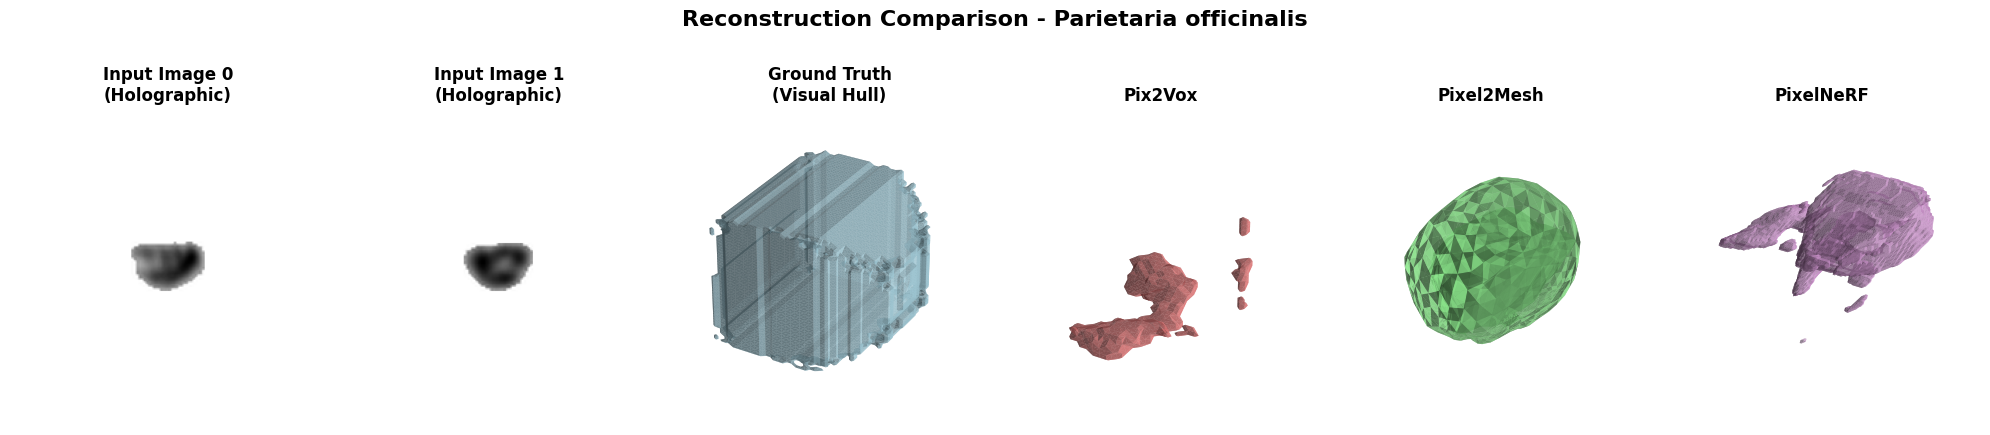

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.792529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_parietaria_s_officinalis_14_2022-09-07_12.08.31.792529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_parietaria_s_officinalis_14_2022-09-07_12.08.31.792529.obj
[DEBUG] Found

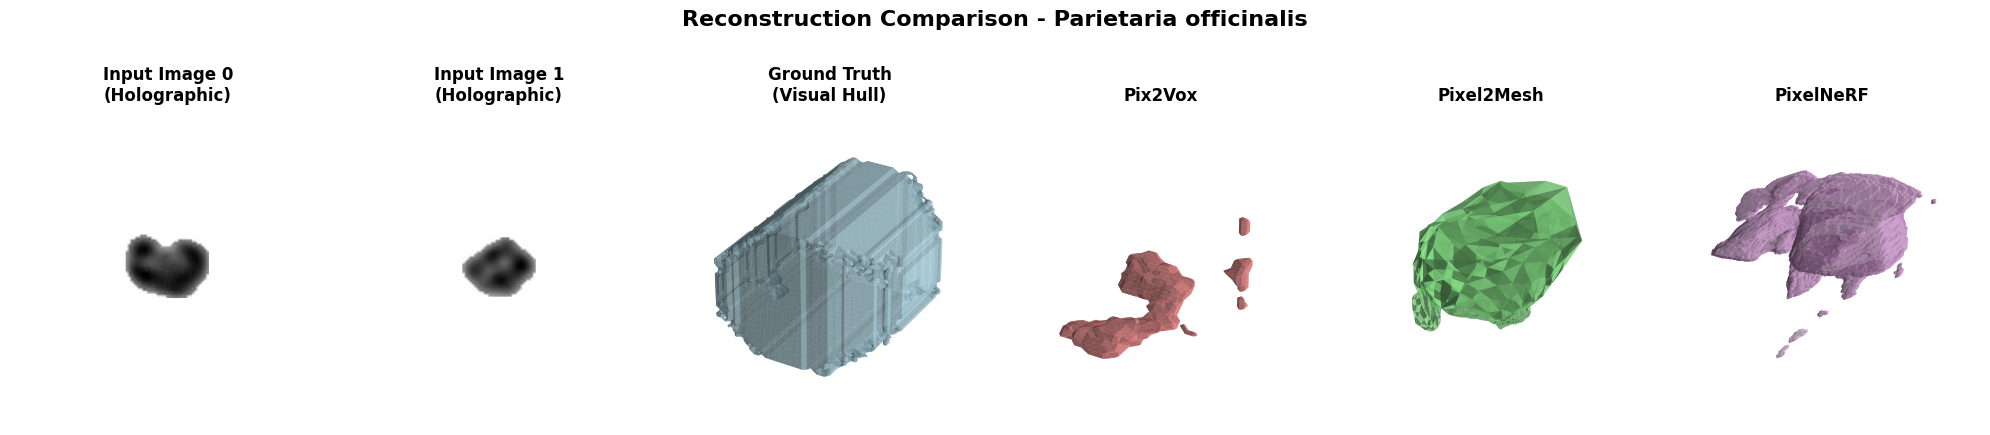

[DEBUG] GT found: C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.947529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'poleno-14_2022-09-07_12.08.31.947529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl' (pix2vox_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\pix2vox_aug_holo_test\poleno-14_2022-09-07_12.08.31.947529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\vh_2img_holo_test\poleno-14_2022-09-07_12.08.31.947529_ev.computed_data.holography.image_pairs.0.0.rec_mag.stl
[DEBUG] Found mesh files for 'g_urtica_s_dioica_14_2022-09-07_12.08.31.947529.obj' (pixel2mesh_file):
   C:/Users/super/Documents/Github/sequoia/TestEvaluationPipeline/data_holo\Pixel2MeshPlusPlus\g_urtica_s_dioica_14_2022-09-07_12.08.31.947529.obj
[DEBUG] Found mesh files for 'g

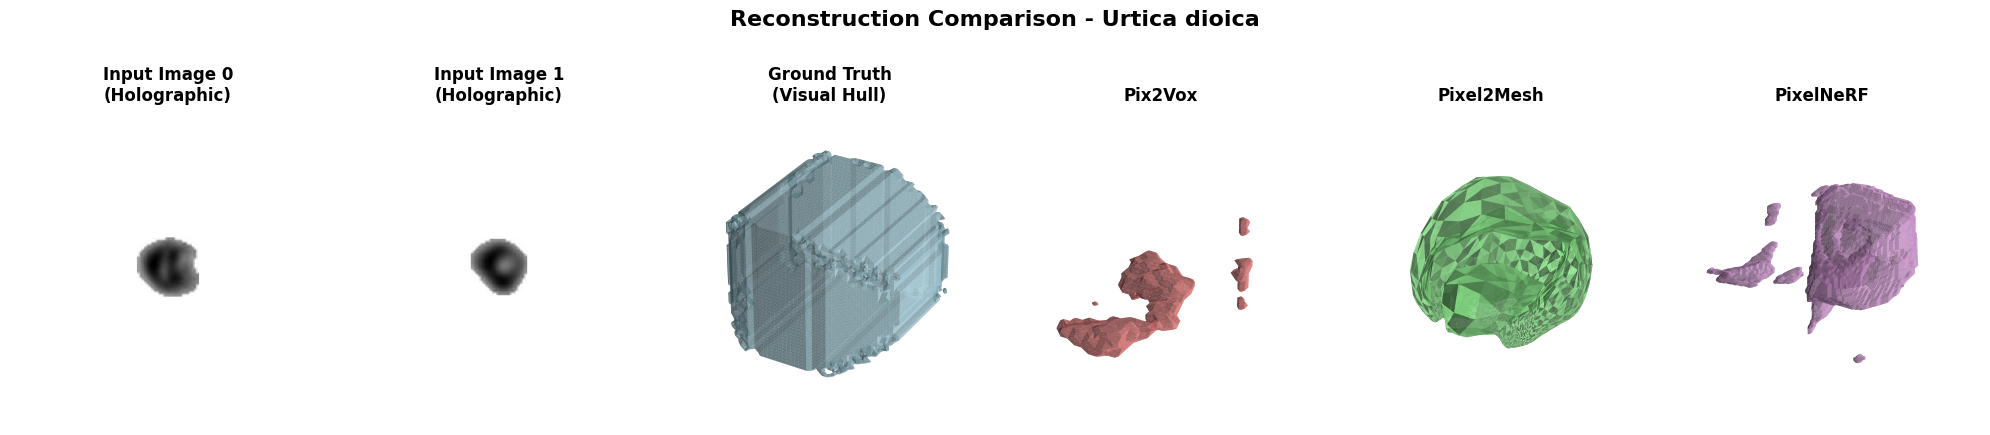


Processing complete:
Successful: 21/21
Failed: 0/21
Success rate: 100.0%


In [14]:
# Enhanced Production Execution with Full Feature Testing
print("Testing enhanced system integration...")
dataloader_ok = test_dataloader_integration()
metrics_ok = test_metrics_integration()


print(f"\nSystem Status:")

print(f"DataLoader: {'✓' if dataloader_ok else '✗'}")
print(f"Metrics: {'✓' if metrics_ok else '✗'}")


if dataloader_ok and metrics_ok:
    print(
        "\nFull enhanced system ready! Processing with wireframes, transparency, and metrics..."
    )
    process_all()
elif dataloader_ok:
    print("\nDataLoader ready! Processing with enhanced visualization (no metrics)...")
    process_all()
else:
    print("\nUsing fallback method with enhanced rendering...")
    process_all()